In [1]:
import pandas as pd
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import dill as pickle
import warnings

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from lightgbm import LGBMRegressor  
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 400)

## 데이터 전처리 : 이상치 제거

In [2]:
data = pd.read_csv(r'UK_car.csv')
used_car = data.copy()

In [3]:
used_car.head()

brand model  year  price transmission  mileage fuelType   mpg  engineSize
0  Audi    A1  2017  12500       Manual    15735   Petrol  55.4         1.4
1  Audi    A6  2016  16500    Automatic    36203   Diesel  64.2         2.0
2  Audi    A1  2016  11000       Manual    29946   Petrol  55.4         1.4
3  Audi    A4  2017  16800    Automatic    25952   Diesel  67.3         2.0
4  Audi    A3  2019  17300       Manual     1998   Petrol  49.6         1.0

In [4]:
used_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         108540 non-null  object 
 1   model         108540 non-null  object 
 2   year          108540 non-null  int64  
 3   price         108540 non-null  int64  
 4   transmission  108540 non-null  object 
 5   mileage       108540 non-null  int64  
 6   fuelType      108540 non-null  object 
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 7.5+ MB


In [ ]:
# int형 year의 값은 회귀 계수 계산시 영향을 끼칠 수 있으므로, str으로 바꿔준 뒤 나중에 One-Hot-Encoding을 수행할 것이다.
# used_car['year'] = used_car['year'].astype(str)

In [ ]:
# Feature간 상관관계 파악
used_car.corr()

price   mileage       mpg  engineSize
price       1.000000 -0.427944 -0.296429    0.631580
mileage    -0.427944  1.000000  0.185657    0.108246
mpg        -0.296429  0.185657  1.000000   -0.248210
engineSize  0.631580  0.108246 -0.248210    1.000000

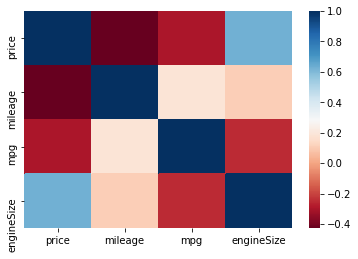

In [ ]:
## 다중공선성 문제 발생 대비 상관관계 파악
## price에는 engineSize가 약한 상관을 보임, 피처들간 상관은 문제가 되지 않는다.
corr = used_car.corr()
sns.heatmap(corr, cmap='RdBu')

In [ ]:
# 타겟값 price와 brand간 이상치 확인
fig = px.scatter(used_car, x='brand', y='price')
fig.show()

In [5]:
# Hyundai 자동차의 이상치 값 확인
used_car[used_car['brand']=='Hyundai'].sort_values(by='price', ascending=False)

brand    model  year  price  ... mileage  fuelType   mpg  engineSize
53014  Hyundai      I10  2017  92000  ...   35460    Petrol  47.9         1.2
50752  Hyundai  SantaFe  2020  43995  ...      10    Diesel  39.2         2.2
51460  Hyundai  SantaFe  2019  40365  ...       1    Diesel  39.2         2.2
52180  Hyundai  SantaFe  2020  37995  ...       9    Diesel  39.2         2.2
52561  Hyundai  SantaFe  2020  36999  ...    2885    Diesel  39.2         2.2
...        ...      ...   ...    ...  ...     ...       ...   ...         ...
53451  Hyundai      I10  2008   1495  ...   94000    Petrol  56.5         1.2
53261  Hyundai      I30  2008   1395  ...  138000    Diesel  57.6         1.6
53076  Hyundai   Accent  2000   1295  ...   47000    Petrol  38.7         1.3
53539  Hyundai     Getz  2007   1295  ...   90800    Petrol  51.4         1.1
53472  Hyundai  SantaFe  2002   1200  ...   94000    Petrol  30.4         2.4

[4860 rows x 9 columns]

In [ ]:
used_car.columns

Index(['brand', 'model', 'year', 'price', 'transmission', 'mileage',
       'fuelType', 'mpg', 'engineSize'],
      dtype='object')

In [ ]:
## outlier 파악
fig = px.scatter(used_car, x='brand', y='price')
fig.show()

In [ ]:
# bmw 이상치 index 확인
print(used_car[used_car['price']==99950])
print(used_car[used_car['price']==123456])
# skoda 이상치 index 확인
print(used_car[used_car['price']==91874])
# vauxhall 이상치 index 확인
print(used_car[used_car['price']==52489])
print(used_car[used_car['price']==39000])
# hyundai 이상치 index 확인
print(used_car[used_car['price']==92000])

      brand   model  year  price  ... mileage  fuelType   mpg  engineSize
16030   BMW      M4  2016  99950  ...     771    Petrol  33.2         3.0
54313  Benz  AClass  2019  99950  ...    2013    Petrol  22.6         4.0

[2 rows x 9 columns]
      brand    model  year   price  ... mileage  fuelType   mpg  engineSize
14306   BMW  2Series  2015  123456  ...   33419    Diesel  68.9         2.0

[1 rows x 9 columns]
       brand  model  year  price  ... mileage  fuelType   mpg  engineSize
71739  Skoda  Karoq  2019  91874  ...    3764    Petrol  40.9         1.5

[1 rows x 9 columns]
          brand  model  year  price  ... mileage  fuelType   mpg  engineSize
86793  Vauxhall  Mokka  2016  52489  ...   52489    Diesel  55.4         1.6

[1 rows x 9 columns]
          brand     model  year  price  ... mileage  fuelType   mpg  engineSize
3297       Audi        Q5  2020  39000  ...    1000    Diesel  38.2         2.0
3842       Audi        Q3  2020  39000  ...    3500    Diesel  46.3         

In [ ]:
# BMW 가격 이상치 삭제
used_car.drop([16030, 54313], inplace=True)
used_car.drop([53014], inplace=True)

In [ ]:
used_car.drop([14306], inplace=True)

In [ ]:
# 벤츠 이상치 값 삭제
used_car.drop([62364], inplace=True)

In [ ]:
# 스코다 이상치 값 삭제
used_car.drop([71739], inplace=True)

In [ ]:
# vauxhall 이상치 값 삭제
used_car.drop([86793], inplace=True)

In [ ]:
# feature들의 outlier를 찾기위한 시각화
cols = used_car.columns

In [ ]:
cols = ['brand', 'model', 'year', 'transmission', 'mileage',
       'fuelType', 'mpg', 'engineSize']

In [ ]:
# 타겟값 price와 피처값 columns간 그래프 시각화
for col in cols:
  fig = px.scatter(used_car, x=col, y='price')
  fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 전처리 된 price가격 확인
fig = px.scatter(used_car, x='brand', y='price')
fig.show()

In [ ]:
## 년도 이상치 제거 : 2020년 기준
used_car = used_car[used_car['year']<2021]

In [ ]:
# MPG 이상치 제거
used_car = used_car[used_car['mpg']<400]

In [ ]:
# Null값이 존재하는 mpg 컬럼은 평균값으로 대체
np.mean(used_car['mpg'])

54.987630325999255

In [ ]:
# Null값이 존재하는 mpg 컬럼은 평균값으로 대체
used_car.mpg.fillna(np.mean(used_car['mpg']), inplace=True)

## 회귀모형 모델링

In [ ]:
used_car.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99136 entries, 0 to 108539
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         99136 non-null  object 
 1   model         99136 non-null  object 
 2   year          99136 non-null  int64  
 3   price         99136 non-null  int64  
 4   transmission  99136 non-null  object 
 5   mileage       99136 non-null  int64  
 6   fuelType      99136 non-null  object 
 7   mpg           99136 non-null  float64
 8   engineSize    99136 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 7.6+ MB


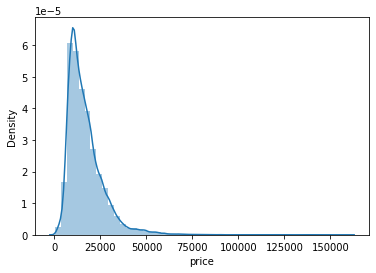

In [ ]:
# target값인 price의 분포 확인 : 정규분포가 아닌 왜곡된 형태
# 예측 모델의 성능에 영향을 줄 가능성이 있으므로 정규분포로 변환
sns.distplot(used_car['price'])

In [ ]:
temp = used_car.copy()
temp = pd.get_dummies(temp, columns=['brand', 'model', 'year', 'transmission',
       'fuelType'])

# target값의 분포가 왜곡되어 있으므로, log변환을 통해 정규분포에 가깝도록 변환
temp['price'] = np.log1p(temp['price'])

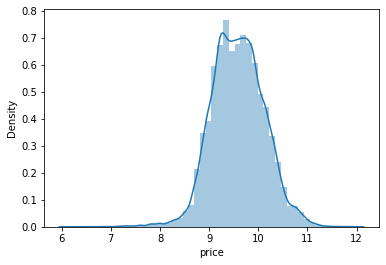

In [ ]:
# 로그변환한 target값의 분포확인
sns.distplot(temp['price'])

In [ ]:
# 타겟 데이터
y_target = temp['price']
# 피처 데이터
X_features = temp.drop('price', axis=1)

# test_split_split()으로 train,test set 분리
# X_train, y_train은 학습용 데이터 셋, X_test는 예측용, y_test는 예측한 것과 비교할 평가용
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=77)

In [ ]:
# LinearRegression() 모델로 학습
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
# LinearRegression() 모델로 예측
y_preds = linear_reg.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
r_square = r2_score(y_test, y_preds)

print('MSE : {0:.3f}, RMSE : {1:.4f}'.format(mse, rmse))
print('R_Square : {0:.3f}'.format(r_square))

MSE : 0.016, RMSE : 0.1265
R_Square : 0.945


In [ ]:
# Ridge() 모델로 학습
ridge = Ridge(alpha=0.001)
ridge.fit(X_train, y_train)
# Ridge() 모델로 예측
y_preds = ridge.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
# r_square = r2_score(y_test, y_preds)

print('MSE : {0:.3f}, RMSE : {1:.4f}'.format(mse, rmse))
print('R_Square : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 0.016, RMSE : 0.1265
R_Square : 0.945


In [ ]:
# Lasso() 모델로 학습
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train, y_train)
# Lasso() 모델로 예측
y_preds = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
r_square = r2_score(y_test, y_preds)

print('MSE : {0:.3f}, RMSE : {1:.4f}'.format(mse, rmse))
print('R_Square : {0:.3f}'.format(r_square))

MSE : 0.017, RMSE : 0.1318
R_Square : 0.941


In [ ]:
# ridge : cross_val_score()함수로 K-Fold 검증, R_sqaure값 확인

# alpha값 적용
alphas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 3, 5, 10, 30, 50]
for alpha in alphas :
    
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    # Ridge() 모델로 예측
    y_preds = ridge.predict(X_test)
    mse = mean_squared_error(y_test, y_preds)
    rmse = np.sqrt(mse)
    r_square = r2_score(y_test, y_preds)

    # cross_val_score 값 출력
    print('Ridge alpha : {0}, RMSE : {1:.4f}'.format(alpha, rmse))
    print('Ridge alpha : {0}, r2_score : {1:.3f}'.format(alpha, r_square))

print('---------------------------------------------')

# alpha값 적용
alphas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5]
for alpha in alphas :
    lasso = Lasso(alpha=alpha)

    # Lasso() 모델로 학습
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    # Lasso() 모델로 예측
    y_preds = lasso.predict(X_test)
    mse = mean_squared_error(y_test, y_preds)
    rmse = np.sqrt(mse)
    r_square = r2_score(y_test, y_preds)

    # cross_val_score 값 출력
    print('Lasso alpha : {0}, RMSE : {1:.4f}'.format(alpha, rmse))
    print('Lasso alpha : {0}, r2_score : {1:.3f}'.format(alpha, r_square))

Ridge alpha : 0.0001, RMSE : 0.1265
Ridge alpha : 0.0001, r2_score : 0.944
Ridge alpha : 0.001, RMSE : 0.1265
Ridge alpha : 0.001, r2_score : 0.944
Ridge alpha : 0.01, RMSE : 0.1265
Ridge alpha : 0.01, r2_score : 0.944
Ridge alpha : 0.05, RMSE : 0.1264
Ridge alpha : 0.05, r2_score : 0.944
Ridge alpha : 0.1, RMSE : 0.1264
Ridge alpha : 0.1, r2_score : 0.944
Ridge alpha : 0.5, RMSE : 0.1264
Ridge alpha : 0.5, r2_score : 0.944
Ridge alpha : 1, RMSE : 0.1266
Ridge alpha : 1, r2_score : 0.944
Ridge alpha : 3, RMSE : 0.1271
Ridge alpha : 3, r2_score : 0.944
Ridge alpha : 5, RMSE : 0.1276
Ridge alpha : 5, r2_score : 0.943
Ridge alpha : 10, RMSE : 0.1289
Ridge alpha : 10, r2_score : 0.942
Ridge alpha : 30, RMSE : 0.1337
Ridge alpha : 30, r2_score : 0.938
Ridge alpha : 50, RMSE : 0.1380
Ridge alpha : 50, r2_score : 0.934
---------------------------------------------
Lasso alpha : 0.0001, RMSE : 0.1339
Lasso alpha : 0.0001, r2_score : 0.938
Lasso alpha : 0.001, RMSE : 0.1808
Lasso alpha : 0.001,

In [ ]:
# Ridge와 Lasso모델 결합한 결과
ridge = Ridge(alpha=0.001)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha=0.0001)
lasso.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
lasso_pred = lasso.predict(X_test)

pred = 0.7*ridge_pred + 0.3*lasso_pred
res_mse = mean_squared_error(y_test, pred)
res_rmse = np.sqrt(res_mse)

print('Ridge와 Lasso를 7:3 비율로 결합해 예측한 RMSE값 : ', np.round(res_rmse,4))

Ridge와 Lasso를 7:3 비율로 결합해 예측한 RMSE값 :  0.1272


In [ ]:
# linear_reg : cross_val_score()함수로 K-Fold 검증
neg_mse = cross_val_score(linear_reg, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
r2_score = cross_val_score(linear_reg, X_features, y_target, scoring='r2', cv=5)
rmse = np.sqrt(-1*neg_mse)
avg_rmse = np.mean(rmse)
avg_r2_score = np.mean(r2_score)

# cross_val_score 값 출력
print('Linear_reg cv = 5의 평균 RMSE : {0:.3f}'.format(avg_rmse))
print('Linear_reg cv = 5의 r2_score : {0:.3f}'.format(avg_r2_score))

Linear_reg cv = 5의 평균 RMSE : 0.263
Linear_reg cv = 5의 r2_score : 0.663


In [ ]:
# linear_reg : cross_val_score()함수로 K-Fold 검증
neg_mse = cross_val_score(linear_reg, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
r2_score = cross_val_score(linear_reg, X_features, y_target, scoring='r2', cv=5)
rmse = np.sqrt(-1*neg_mse)
avg_rmse = np.mean(rmse)
avg_r2_score = np.mean(r2_score)

# cross_val_score 값 출력
print('Linear_regression RMSE : {0:.3f}'.format(avg_rmse))

Linear_regression RMSE : 0.263
Ridge RMSE : 0.256, best_alpha : {'alpha': 100}
Lasso RMSE : 0.257, best_alpha : {'alpha': 0.001}


In [ ]:
# GridSearchCV를 이용해 하이퍼파라미터 튜닝 및 교차검증
ridge_params = {'alpha':[0.001, 0.01, 0.05, 0.1, 0.5, 1, 3, 5, 10, 50, 70, 90, 100]}
ridge_grid = GridSearchCV(ridge, param_grid=ridge_params, scoring='neg_mean_squared_error',cv=5)
ridge_grid.fit(X_features, y_target)
rmse = np.sqrt(-1*ridge_grid.best_score_)
# ridge의 최적 파라미터로 세팅
ridge = ridge_grid.best_estimator_
print('Ridge RMSE : {0:.3f}, best_alpha : {1}'.format(np.round(rmse,3), ridge_grid.best_params_))

lasso_params = {'alpha':[0.001, 0.01, 0.05, 0.1, 0.5, 1, 5]}
lasso_grid = GridSearchCV(lasso, param_grid=lasso_params, scoring='neg_mean_squared_error',cv=5)
lasso_grid.fit(X_features, y_target)
rmse = np.sqrt(-1*lasso_grid.best_score_)
# lasso의 최적 파라미터로 세팅
lasso = lasso_grid.best_estimator_
print('Lasso RMSE : {0:.3f}, best_alpha : {1}'.format(np.round(rmse,3), lasso_grid.best_params_))

In [ ]:
# Ridge : 최적 alpha값으로 setting
ridge_model = Ridge(alpha=100)
ridge_model.fit(X_train, y_train)
# 회귀 계수 값 시각화
df = pd.DataFrame()
coef = pd.Series(data=ridge_model.coef_, index=X_features.columns)
df['coef'] = coef
coef = coef.sort_values(ascending=True)
fig = go.Figure(go.Bar(x=coef.values, y=coef.index, orientation='h'))
fig.show()

In [ ]:
# Lasso : 최적 alpha값으로 setting
lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train, y_train)
# 회귀 계수 값 시각화
df = pd.DataFrame()
coef = pd.Series(data=lasso_model.coef_, index=X_features.columns)
df['coef'] = coef
coef = coef.sort_values(ascending=True)
fig = go.Figure(go.Bar(x=coef.values, y=coef.index, orientation='h'))
fig.show()

In [ ]:
# GridSearchCV를 이용해 LGBM모델의 하이퍼파라미터 튜닝 및 교차검증
lgbm_params = {'n_estimators':[1000],
               'learning_rate':[0.01, 0.05, 0.1],
               'max_depth':[6, 16, 32],
              'subsample':[0.6,0.8]}
lgbm_model = LGBMRegressor(n_jobs=-1)
lgbm_grid = GridSearchCV(lgbm_model, param_grid=lgbm_params, 
                         scoring='neg_mean_squared_error', cv=5, verbose=2)
lgbm_grid.fit(X_features, y_target)
rmse = np.sqrt(-1*lgbm_grid.best_score_)
lgbm_model = lgbm_grid.best_estimator_
print('lgbm RMSE : {0:.3f}, best_parameters : {1}'.format(np.round(rmse,3), lgbm_grid.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.6, total=   5.5s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.6, total=   5.7s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.6 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.6, total=   5.6s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.6 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.6, total=   5.9s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.6 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.6, total=   5.7s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.8, total=   5.5s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.8, total=   5.7s
[CV] learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=6, n_estim

In [ ]:
# 모델들을 바탕으로 최종 스태킹 앙상블 구현
# https://lsjsj92.tistory.com/559?category=853217 코드를 사용하였습니다.

def get_stacking_data(model, X_train, y_train, X_test, n_folds=5):
    kfold = KFold(n_splits = n_folds, random_state=0)

    # 최종 모델에서 사용할 데이터 셋 세팅(0 값으로)
    # 만약 shape가 (100, 10)이었으면 폴드의 검증에 사용할 저장할 데이터는 (100,1) 모양
    train_fold_predict = np.zeros((X_train.shape[0], 1))
    # test는 X_test값을 이용해서 매 폴드마다 예측을 하므로, (100, fold 수)만큼의 shape을 갖는다.
    # 그래서 폴드마다 X_test의 예측 값을 해당 fold의 열에 삽입
    test_predict = np.zeros((X_test.shape[0], n_folds))
    print('model : ', model.__class__.__name__)

    for cnt,(train_index, valid_index) in enumerate(kfold.split(X_train)):
        X_train_ = X_train[train_index]
        y_train_ = y_train[train_index]
        X_validation = X_train[valid_index]

        model.fit(X_train_, y_train_)

        # 해당 폴드에서 학습된 모델에 검증 데이터(X_validation)으로 예측 후 저장
        train_fold_predict[valid_index, :] = model.predict(X_validation).reshape(-1,1)

        # 해당 폴드에서 생성된 모델에 원본 테스트 데이터(X_test)를 이용해서 예측후 저장
        test_predict[:, cnt] = model.predict(X_test)

    # for문 끝나면 test_pred는 평균을 내서 하나로 합친다.
    test_predict_mean = np.mean(test_predict, axis=1).reshape(-1,1)

    return train_fold_predict, test_predict_mean

X_train_ = X_train.values
X_test_ = X_test.values
y_train_ = y_train.values

ridge_train, ridge_test = get_stacking_data(ridge_model, X_train_, y_train_, X_test_, 5)
lasso_train, lasso_test = get_stacking_data(lasso_model, X_train_, y_train_, X_test_, 5)
lgbm_train, lgbm_test = get_stacking_data(lgbm_model, X_train_, y_train_, X_test_, 5)

# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, lgbm_test), axis=1)

meta_model = Lasso(alpha=0.001)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측
meta_model.fit(Stack_final_X_train, y_train)
final = meta_model.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('Stacking meta 모델의 RMSE 값 : ', rmse)

In [ ]:
# 예측한 결과값 final과 실제값 y_test 사이의 오차값 계산
res = np.expm1(final)
ori = np.expm1(y_test)

np.mean(np.abs(ori-res))

print('오차 금액 :', int(round(1480*mean_absolute_error(res, ori), -3)), '원')

오차 금액 : 1842000 원


In [ ]:
# input 데이터를 받아 카테코리형 변수들을 One-Hot-Encoding으로 변환해주는 함수
# input 변수 : ['brand', 'model', 'year', 'transmission', 'mileage', 'fuelType', 'mpg', 'enzineSize']
def input_data(df):
    tmp = pd.read_csv('preprocessed_UK_car.csv')
    tmp.drop(columns=['price'], inplace=True)
    input = pd.concat([tmp,df])
    result = pd.get_dummies(input, columns=['brand', 'model', 'year', 'transmission','fuelType'])
    result = result.tail(1)
    print(result.head())
    return result

In [ ]:
# input 데이터를 One-Hot-Encoding을 거친후, 학습한 모델들을 불러와서 최종 결과를 예측하는 함수
# input 변수 : ['brand', 'model', 'year', 'transmission', 'mileage', 'fuelType', 'mpg', 'enzineSize']
def modeling(df):
    # Ridge, Lasso, LGBM, Meta_model을 로드
    with open('ridge_model.txt', 'rb') as f:
        ridge_model = pickle.load(f)

    with open('lasso_model.txt', 'rb') as f:
        lasso_model = pickle.load(f)

    with open('lgbm_model.txt', 'rb') as f:
        lgbm_model = pickle.load(f)

    with open('meta_model.txt', 'rb') as f:
        meta_model = pickle.load(f)
    
    # input_data함수를 이용해 One-Hot-Ecoding
    res = input_data(df)

    pred = []
    pred1 = ridge_model.predict(res)
    pred2 = lasso_model.predict(res)
    pred3 = lgbm_model.predict(res)
    pred.append(pred1[0])
    pred.append(pred2[0])
    pred.append(pred3[0])
    pred = [pred]

    # meta_model을 통해 최종 결과 예측 
    result = 1474*np.expm1(meta_model.predict(pred)[0])
    return int(round(result,-3))

In [ ]:
## 테스트
tmp = pd.read_csv('preprocessed_UK_car.csv')
tmp.drop(columns=['price'], inplace=True)
df = [['Audi',	'A1',	2017,	'Manual',	15735,	'Petrol',	55.4,	1.4]]
df = pd.DataFrame(df, columns=tmp.columns)
print(modeling(df), '원')

   mileage   mpg  engineSize  ...  fuelType_Hybrid  fuelType_Other  fuelType_Petrol
0    15735  55.4         1.4  ...                0               0                1

[1 rows x 243 columns]
20263000 원


In [ ]:
# 학습한 모델을 Binary 형태로 저장
with open('meta_model.txt', 'wb') as file:
    pickle.dump(meta_model, file)

with open('ridge_model.txt', 'wb') as file:
    pickle.dump(ridge_model, file)

with open('lasso_model.txt', 'wb') as file:
    pickle.dump(lasso_model, file)

with open('lgbm_model.txt', 'wb') as file:
    pickle.dump(lgbm_model, file)

In [ ]:
# 모델 load
with open('ridge_model.txt', 'rb') as f:
    ridge_model = pickle.load(f)

with open('lasso_model.txt', 'rb') as f:
    lasso_model = pickle.load(f)

with open('lgbm_model.txt', 'rb') as f:
    lgbm_model = pickle.load(f)
    
with open('meta_model.txt', 'rb') as f:
    meta_model = pickle.load(f)